# Predicting Other Quality Measures using Trees



In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor 

In [2]:
# Let's start by loading in our train and test datasets
df_train = pd.read_csv('train_data.csv')
df_test = pd.read_csv('test_data.csv')

df_train.head(3)

,Species,Country.of.Origin,Number.of.Bags,In.Country.Partner,Variety,Processing.Method,Aroma,Flavor,Aftertaste,Acidity,...,Cupper.Points,Total.Cup.Points,Moisture,Category.One.Defects,Quakers,Color,Category.Two.Defects,altitude_low_meters,altitude_high_meters,quality
0,Arabica,"Tanzania, United Republic Of",300,Tanzanian Coffee Board,Arusha,Washed / Wet,7.67,7.5,7.33,7.25,...,7.75,82.83,0.11,0,0.0,Green,5,1400.0,1400.0,excellent
1,Arabica,Brazil,25,NUCOFFEE,Mundo Novo,Semi-washed / Semi-pulped,7.75,7.5,7.58,7.50,...,7.58,83.17,0.12,0,0.0,Blue-Green,3,1000.0,1000.0,excellent
2,Arabica,"Tanzania, United Republic Of",1,Africa Fine Coffee Association,Other,Washed / Wet,7.42,7.5,7.50,7.33,...,7.50,82.08,0.12,0,0.0,Green,3,1500.0,1700.0,excellent


In [3]:
df_train.columns[6:17]

Index(['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance',
       'Uniformity', 'Clean.Cup', 'Sweetness', 'Cupper.Points',
       'Total.Cup.Points'],
      dtype='object')

<AxesSubplot:>

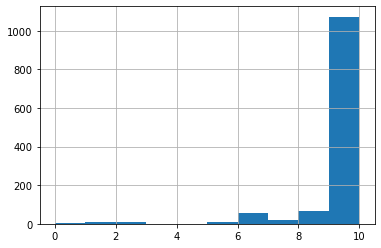

In [31]:
# not a ton of variation in quality measures
df_train['Aroma'].sort_values()
df_train['Flavor'].sort_values()
df_train['Aftertaste'].sort_values()
df_train['Acidity'].sort_values()
df_train['Body'].sort_values()
df_train['Balance'].sort_values()
df_train['Uniformity'].sort_values()
df_train['Clean.Cup'].sort_values()
df_train['Sweetness'].sort_values()

df_train['Clean.Cup'].hist()

In [5]:
# drop Total.Cup.Points and Cupper.Points as well as extra features
df_train = df_train.drop(['Total.Cup.Points','Cupper.Points','Country.of.Origin', 'In.Country.Partner', 'Variety'], axis=1)
df_test = df_test.drop(['Total.Cup.Points','Cupper.Points','Country.of.Origin', 'In.Country.Partner', 'Variety'],axis=1)

# And we'll also shuffle for good measure
df_train = df_train.sample(frac=1.0, random_state=0)
df_test = df_test.sample(frac=1.0, random_state=0)

df_train.head(3)

,Species,Number.of.Bags,Processing.Method,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean.Cup,Sweetness,Moisture,Category.One.Defects,Quakers,Color,Category.Two.Defects,altitude_low_meters,altitude_high_meters,quality
1034,Arabica,50,Washed / Wet,7.08,7.08,7.25,7.00,7.17,7.17,10.0,10.0,10.0,0.10,0,0.0,Blue-Green,0,500.0,700.0,very good
124,Arabica,10,Natural / Dry,7.58,7.67,7.58,7.33,7.00,7.58,10.0,10.0,10.0,0.15,1,0.0,None,8,441.0,441.0,excellent
184,Arabica,44,Washed / Wet,7.58,7.58,7.25,7.58,7.42,7.50,10.0,10.0,10.0,0.11,0,0.0,Green,2,950.0,950.0,excellent


In [6]:
# Now we can define our target and features
target = 'Uniformity'
X_train = df_train.drop([target], axis=1)
X_test = df_test.drop([target], axis=1)

y_train = df_train[target]
y_test = df_test[target]

In [7]:
# We'll get dummies for the categorical data and standardize the numerical columns
X_train_num = X_train.select_dtypes(include='number')
X_train_cat = X_train.select_dtypes(exclude='number')

X_train_cat = pd.get_dummies(X_train_cat)
X_train_num = (X_train_num - X_train_num.mean()) / X_train_num.std()

X_train = pd.concat([X_train_num, X_train_cat], axis=1)

X_test_num = X_test.select_dtypes(include='number')
X_test_cat = X_test.select_dtypes(exclude='number')

X_test_cat = pd.get_dummies(X_test_cat)
X_test_num = (X_test_num - X_test_num.mean()) / X_test_num.std()

X_test = pd.concat([X_test_num, X_test_cat], axis=1)

In [8]:
print(X_train.shape)
X_train.head(3)

(1244, 28)


,Number.of.Bags,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Clean.Cup,Sweetness,Moisture,...,Processing.Method_Other,Processing.Method_Pulped natural / honey,Processing.Method_Semi-washed / Semi-pulped,Processing.Method_Washed / Wet,Color_Blue-Green,Color_Bluish-Green,Color_Green,Color_None,quality_excellent,quality_very good
1034,-0.807907,-0.945001,-0.605959,0.184300,-1.078760,-0.694506,-0.332798,0.380905,0.237406,-0.039962,...,0,0,0,1,1,0,0,0,0,1
124,-1.126193,0.507015,0.967374,1.020584,-0.108146,-1.275817,0.722343,0.380905,0.237406,1.196664,...,0,0,0,0,0,0,0,1,1,0
184,-0.855650,0.507015,0.727374,0.184300,0.627169,0.160364,0.516461,0.380905,0.237406,0.207363,...,0,0,0,1,0,0,1,0,1,0


In [9]:
y_test.value_counts()

10.00    166
9.33       9
8.00       4
8.67       3
Name: Uniformity, dtype: int64

In [10]:
# Now let's set up our DecisionTreeRegressor
grid = {'max_depth': np.arange(1, 25)}

Tree = DecisionTreeRegressor()
TreeCV = GridSearchCV(Tree, param_grid=grid, return_train_score=True)

TreeCV.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])},
             return_train_score=True)

In [11]:
print('best depth', TreeCV.best_params_['max_depth'])
print('validation accuracy', TreeCV.best_score_.round(3))

best depth 6
validation accuracy 0.872


In [12]:
#best_tree = DecisionTreeRegressor(max_depth=TreeCV.best_params_['max_depth'])
#best_tree.fit(X_train, y_train)
#print(best_tree.score(X_test, y_test).round(3))
TreeCV.score(X_test,y_test)

-1.2402572120867803

In [13]:
print(X_train.shape)

(1244, 28)


# Now for Random Forest:

In [16]:
# Luckily, our training and test data is already defined in terms of targets and features

grid = {'n_estimators': np.arange(10, 200, 10), 'max_depth': np.arange(1, 25)}

rf = RandomForestRegressor()
rfCV = GridSearchCV(rf, param_grid=grid, return_train_score=True, n_jobs=-1)

In [17]:
rfCV.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24]),
                         'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190])},
             return_train_score=True)

In [18]:
print('n_estimators: ', rfCV.best_params_['n_estimators'], '  max_depth: ', rfCV.best_params_['max_depth'])
print('validation accuracy ', rfCV.best_score_.round(3))

n_estimators:  180   max_depth:  11
validation accuracy  0.923


In [24]:
# Now let's see how we do 
best_forest = RandomForestRegressor(n_estimators=rfCV.best_params_['n_estimators'],max_depth=rfCV.best_params_['max_depth'])
best_forest.fit(X_train, y_train)
print(best_forest.score(X_test, y_test).round(3))

-0.139


In [21]:
feature_importance = pd.Series(best_forest.feature_importances_, index=X_train.columns)
feature_importance.sort_values(ascending=False)

Clean.Cup                                      3.514481e-01
Number.of.Bags                                 1.448028e-01
Moisture                                       1.032499e-01
Category.Two.Defects                           5.591870e-02
altitude_high_meters                           4.299197e-02
Balance                                        4.070325e-02
altitude_low_meters                            4.063575e-02
Flavor                                         3.677701e-02
Aroma                                          3.283696e-02
Category.One.Defects                           2.792285e-02
Acidity                                        2.339188e-02
Sweetness                                      2.089518e-02
Aftertaste                                     1.843965e-02
Body                                           1.361351e-02
quality_very good                              1.162575e-02
Processing.Method_Semi-washed / Semi-pulped    7.738362e-03
quality_excellent                       

<AxesSubplot:>

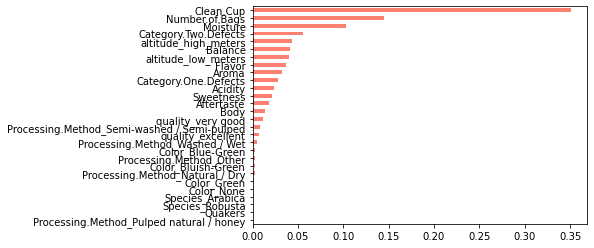

In [22]:
feature_importance.sort_values().plot.barh(color='salmon')